In [1]:
# Import our wrangling and visualization library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("data/marketing_campaign.csv", sep=",")

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04/09/2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08/03/2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21/08/2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/02/2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19/01/2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Exploratory Data Analysis

In [4]:
df["TotalAmountSpent"] = df["MntFishProducts"] + df["MntFruits"] + df["MntGoldProds"] + df["MntSweetProducts"] + df["MntMeatProducts"] + df["MntWines"]

In [5]:
#Year Birth
#We need to convert year birth to an age feature

from datetime import datetime
df["Age"] = df["Year_Birth"].apply(lambda x : datetime.now().year - x)
df["Age"].describe()

count    2240.000000
mean       54.194196
std        11.984069
min        27.000000
25%        46.000000
50%        53.000000
75%        64.000000
max       130.000000
Name: Age, dtype: float64

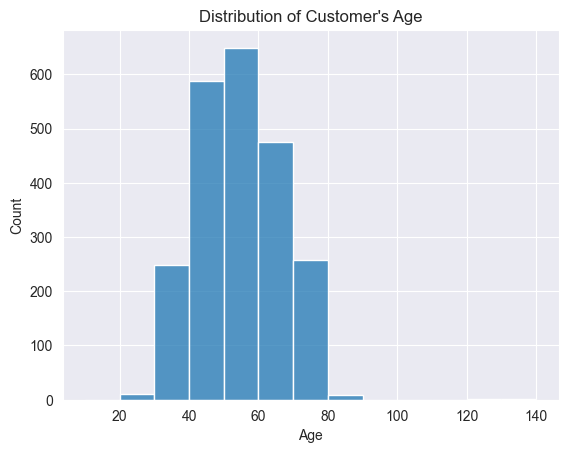

In [6]:
sns.histplot(data=df, x="Age", bins = list(range(10, 150, 10)))
plt.title("Distribution of Customer's Age")
plt.savefig("Age.png")
plt.show()

# Education

In [7]:
df["Education"] = df["Education"].replace({"Graduation":"Graduate", "PhD":"Postgraduate", "Master":"Postgraduate", "2n Cycle":"Postgraduate", "Basic":"Undergraduate"})

In [8]:
df["Education"].value_counts()

Education
Graduate         1127
Postgraduate     1059
Undergraduate      54
Name: count, dtype: int64

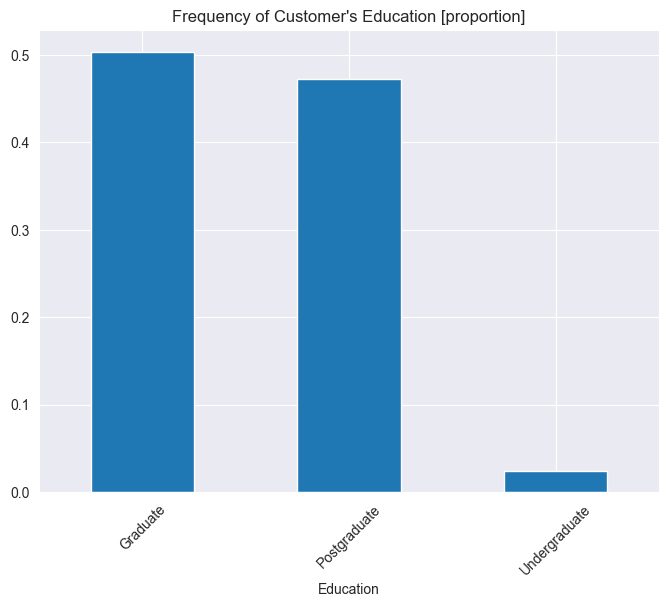

In [9]:
df["Education"].unique()

df["Education"].value_counts(normalize=True).plot.bar(figsize=(8, 6))

plt.xticks(rotation=45)
plt.title("Frequency of Customer's Education [proportion]");

# Income

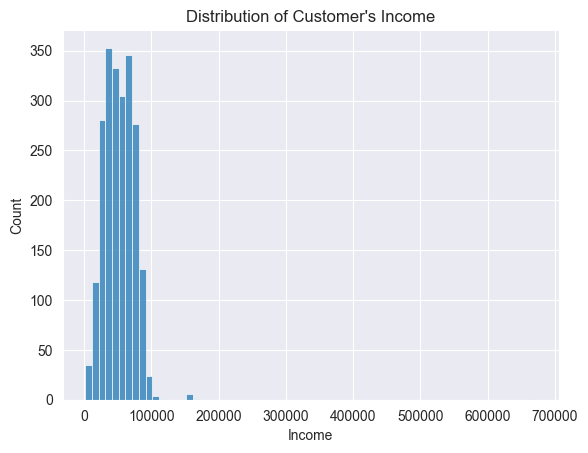

In [10]:
sns.histplot(data=df, x="Income", binwidth=1e4)
plt.title("Distribution of Customer's Income");

# Total Spent

In [11]:
df["TotalAmountSpent"].describe()


count    2240.000000
mean      605.798214
std       602.249288
min         5.000000
25%        68.750000
50%       396.000000
75%      1045.500000
max      2525.000000
Name: TotalAmountSpent, dtype: float64

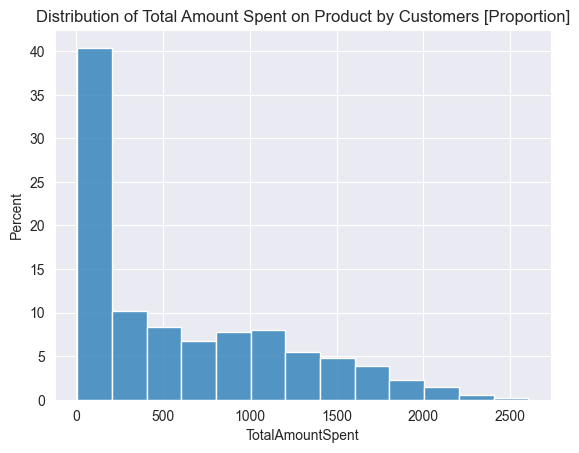

In [12]:
sns.histplot(data=df, x="TotalAmountSpent", binwidth=200, stat="percent")
plt.title("Distribution of Total Amount Spent on Product by Customers [Proportion]");

# Bivariate Analysis

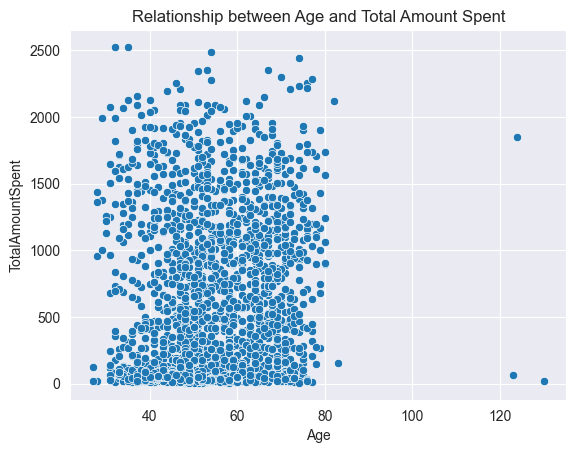

In [13]:
#Age VS Total Amount Spent

sns.scatterplot(data=df, x="Age", y="TotalAmountSpent")
plt.title("Relationship between Age and Total Amount Spent");

In [16]:
# Age groups
def group_age(age):
    if age <20:
        return "11-20"
    elif age > 20 and age <31:
        return "21-30"
    elif age > 30 and age <41:
        return "31-40"
    elif age > 40 and age <51:
        return "41-50"
    elif age > 50 and age <61:
        return "51-60"
    elif age > 60 and age <71:
        return "61-70"
    elif age > 70 and age <81:
        return "71-80"
    elif age > 80:
        return ">80"

df["Age Group"] =df["Age"].apply(group_age)

# To order plotly index
order = ["21-30", "31-40", "41-50", "51-60", "61-70", "71-80", ">80"]

#Education VS Total Amount Spent
mask = df.groupby("Education")["TotalAmountSpent"].median()
mask = mask.reset_index()
fig = px.bar(data_frame=mask, x="Education", y="TotalAmountSpent", height=500,
            title = "Relationsip Between Education and Total Amount Spent [Average Spent]")

annotation = []
for x, y in zip(mask["Education"], mask["TotalAmountSpent"]):
    annotation.append(
        dict(x=x, y=y +20,
             text=str(round(y, 2)) + '$',
             font=dict(family='Arial', size=14, color='rgb(66, 99, 236)'), showarrow=False)
    )
fig.update_xaxes(categoryorder='array', categoryarray= order)
fig.update_layout(annotations=annotation)
fig.show()

# Multivariate Analysis

In [17]:
from scipy.stats import iqr
iqr = iqr(df["Income"], nan_policy="omit")

low = np.nanquantile(df["Income"], 0.25) - 1.5 * iqr
high = np.nanquantile(df["Income"], 0.75) + 1.5 * iqr
df_cut = df[df["Income"].between(low, high)]


#Education VS Income VS TotalAmountSpent
fig = px.scatter(
    data_frame=df_cut,
    x = "Income",
    y= "TotalAmountSpent",
    title = "Relationship between Income VS Total Amount Spent Based on Education",
    color = "Education",
    height=500
)
fig.show()

#How to Calculate The Interquartile Range in Python The interquartile range, often denoted “IQR”, 
#is a way to measure the spread of the middle 50% of a dataset. It is calculated as the difference between the first quartile* 
#(the 25th percentile) and the third quartile (the 75th percentile) of a dataset.

# Conclusion From EDA

# Building the KMeans Model

In [18]:
df["Income"].fillna(df["Income"].median(), inplace=True) #Because the Income feature has missing values, we will fill it with the median number.
data = df[["Income", "TotalAmountSpent"]] #After that, we'll assign the features we want to work with, Income and TotalAmountSpent, to a variable called data.
df_log = np.log(data) #Once that's done we will transform features and save the result into a variable called data_log.


#Then we will scale the result using Scikit-learn StandardScaler():

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_log)

In [19]:
errors = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_scaled)
    errors.append(model.inertia_)
   

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

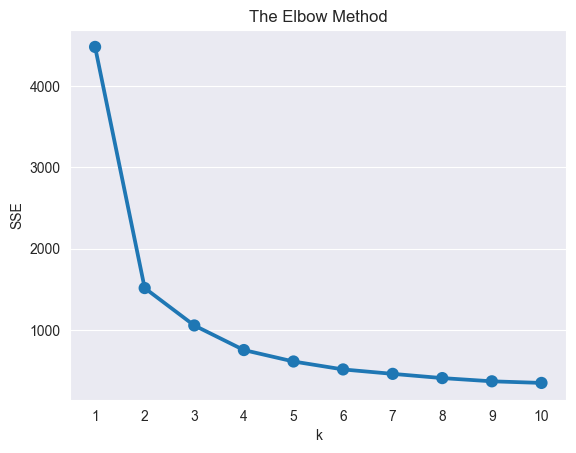

In [20]:
 
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(range(1, 11)), y=errors)
plt.savefig("Elbow.png")

In [21]:
from kneed import KneeLocator
kl = KneeLocator(x = range(1, 11),
                 y = errors,
                 curve="convex",
                 direction="decreasing")
print('The optimum number of clusters is: ' + str(kl.elbow))

The optimum number of clusters is: 3


In [22]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(df_scaled)

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=3, random_state=42)

In [23]:
data = data.assign(ClusterLabel= model.labels_)

In [24]:
data.groupby("ClusterLabel")[["Income", "TotalAmountSpent"]].median()

,Income,TotalAmountSpent
ClusterLabel,,
0,25261.5,43.0
1,69084.0,1069.5
2,42641.0,145.0


In [25]:
fig = px.scatter(
    data_frame=data,
    x = "Income",
    y= "TotalAmountSpent",
    title = "Relationship between Income VS Total Amount Spent",
    color = "ClusterLabel",
    height=500
)
fig.show()

# Building The Kmeans Model with Three Features

In [26]:
data = df[["Age", "Income", "TotalAmountSpent"]]

In [27]:
df_log = np.log(data)
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_log)

In [28]:
sse = {}
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_scaled)
    sse[k] = model.inertia_

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

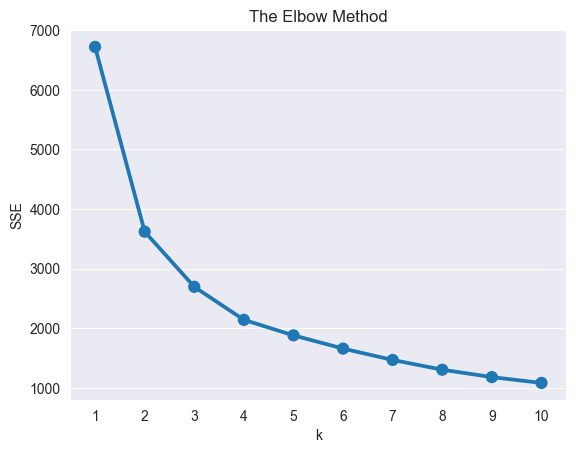

In [29]:
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [30]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(df_scaled)


data = data.assign(ClusterLabel= model.labels_)

/Users/nilsjennissen/.conda/envs/market-research/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [31]:
result = data.groupby("ClusterLabel").agg({"Age":"mean", "Income":"median", "TotalAmountSpent":"median"}).round()

In [32]:
result

,Age,Income,TotalAmountSpent
ClusterLabel,,,
0,50.0,31801.0,54.0
1,45.0,67402.0,1001.0
2,66.0,62814.0,822.0


# Visualizing The Result

In [33]:
fig = px.scatter_3d(data_frame=data, x="Income", 
                    y="TotalAmountSpent", z="Age", color="ClusterLabel", height=550,
                   title = "Visualizing Cluster Result Using 3 Features")
fig.show()